In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
plt.style.use('ggplot')

In [4]:
df = pd.read_csv('clean_adult.csv')

In [5]:
df.head()

,age,workclass,fnlwgt,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,income,from_USA
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,<=50K,1
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,<=50K,1
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,<=50K,1
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,<=50K,1
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,<=50K,0


In [6]:
le = preprocessing.LabelEncoder()
le.fit(df['income'])
df['income'] = le.transform(df['income']) # only target variable

In [7]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
categorical_columns

['workclass', 'marital_status', 'occupation', 'relationship', 'race', 'sex']

In [8]:
for col in categorical_columns:
    df[col] = df[col].astype('category')

In [9]:
X = df.drop('income', axis=1)
y = df['income']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)

### One-Hot encoding

In [11]:
df_enco = pd.get_dummies(df, columns=categorical_columns)

In [12]:
df_enco.head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,income,from_USA,workclass_Federal-gov,workclass_Local-gov,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,39,77516,13,2174,0,40,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
1,50,83311,13,0,0,13,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
2,38,215646,9,0,0,40,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
3,53,234721,7,0,0,40,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0


In [13]:
# df[df['capital_gain'] == 99999]  # mistake?

In [14]:
X_e = df_enco.drop('income', axis=1)
y_e = df_enco['income']

In [15]:
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_e, y_e, test_size=0.25, random_state=16)

### Standardization

In [16]:
X_train_e_std = X_train_e.copy()
scaler_std = preprocessing.StandardScaler().fit(X_train_e[['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']])
columns_scaled = scaler_std.transform(X_train_e[['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']])

In [17]:
X_train_e_std['age'] = columns_scaled[:, 0]
X_train_e_std['fnlwgt'] = columns_scaled[:, 1]
X_train_e_std['education_num'] = columns_scaled[:, 2]
X_train_e_std['capital_gain'] = columns_scaled[:, 3]
X_train_e_std['capital_loss'] = columns_scaled[:, 4]
X_train_e_std['hours_per_week'] = columns_scaled[:, 5]

### Normalization - min max

In [18]:
X_train_e_min = X_train_e.copy()
scaler_min = preprocessing.MinMaxScaler().fit(X_train_e[['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']])
columns_scaled = scaler_min.transform(X_train_e[['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']])

In [19]:
X_train_e_min['age'] = columns_scaled[:, 0]
X_train_e_min['fnlwgt'] = columns_scaled[:, 1]
X_train_e_min['education_num'] = columns_scaled[:, 2]
X_train_e_min['capital_gain'] = columns_scaled[:, 3]
X_train_e_min['capital_loss'] = columns_scaled[:, 4]
X_train_e_min['hours_per_week'] = columns_scaled[:, 5]

In [20]:
def model_scoring(model, model_name, X_train=X_train_e, y_train=y_train_e):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    scores_acc = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    scores_recall = cross_val_score(model, X_train, y_train, scoring='recall', cv=cv, n_jobs=-1)  # sensitivity
    scores_precision = cross_val_score(model, X_train, y_train, scoring='precision', cv=cv, n_jobs=-1)
    scores_roc_auc = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
    
    df_scores = pd.DataFrame({
        'model' : model_name,
        'accuracy' : scores_acc,
        'roc_auc' : scores_roc_auc,
        'recall' : scores_recall,
        'precision' : scores_precision
    })
    return df_scores

# LDA

In [20]:
lda = LinearDiscriminantAnalysis()

In [21]:
df_scores = model_scoring(lda, 'LDA')

# QDA

In [22]:
qda = QuadraticDiscriminantAnalysis()

In [23]:
df_scores = pd.concat([df_scores, model_scoring(qda, 'QDA')], ignore_index=True)

# KNN

1. One hot encoding + Standardization
2. Gower'r distance - predict doesn't work

In [24]:
knn = KNeighborsClassifier(n_neighbors=38)
df_scores = pd.concat([df_scores, model_scoring(knn, 'KNN', X_train=X_train_e_std, y_train=y_train_e)], ignore_index=True)

# Random Forest

In [25]:
rf = RandomForestClassifier()

In [26]:
df_scores = pd.concat([df_scores, model_scoring(rf, 'Random Forest')], ignore_index=True)

# XG Boost

In [55]:
# xg = xgb.XGBClassifier()

In [56]:
# df_scores = pd.concat([df_scores, model_scoring(xg, 'XGBoost')], ignore_index=True)

In [27]:
xg_cat = xgb.XGBClassifier(enable_categorical=True)
df_scores = pd.concat([df_scores, model_scoring(xg_cat, 'XGBoost', X_train=X_train, y_train=y_train)], ignore_index=True)

# Logistic Regression

In [28]:
lr = LogisticRegression()

In [29]:
df_scores = pd.concat([df_scores, model_scoring(lr, 'Logistic regression')], ignore_index=True)

In [30]:
lr_std = LogisticRegression()
df_scores = pd.concat([df_scores, model_scoring(lr_std, 'Logistic regression (std)', X_train=X_train_e_std, y_train=y_train_e)], ignore_index=True)

# Model comparision

In [31]:
df_scores.groupby('model').mean(numeric_only=True) * 100

,accuracy,roc_auc,recall,precision
model,,,,
KNN,84.313136,89.630686,59.195873,72.569098
LDA,83.702488,89.027306,58.725505,70.676662
Logistic regression,79.031406,58.317247,26.475891,70.815303
Logistic regression (std),84.745096,90.298831,60.647336,73.303195
QDA,72.573917,86.740605,87.873780,47.837720
Random Forest,85.006038,90.241734,62.079835,73.472710
XGBoost,86.649855,92.463954,66.031591,76.934490


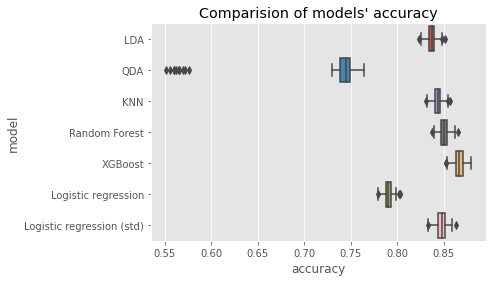

In [32]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_scores, y='model', x='accuracy')
plt.title("Comparision of models' accuracy")
plt.savefig('img/box_1_acc.pdf', bbox_inches='tight')

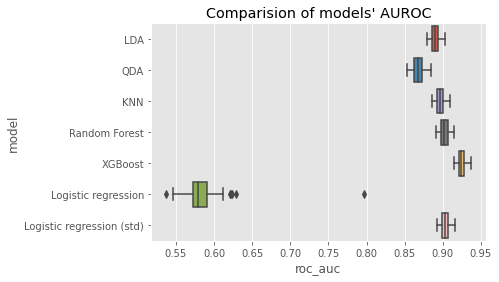

In [33]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_scores, y='model', x='roc_auc')
plt.title("Comparision of models' AUROC")
plt.savefig('img/box_1_roc_auc.pdf', bbox_inches='tight')

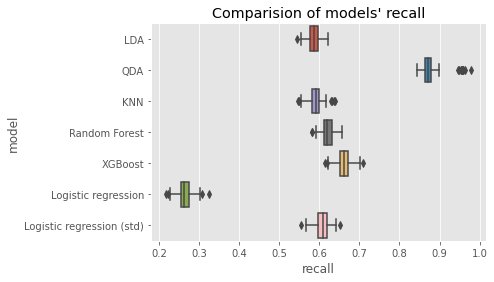

In [34]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_scores, y='model', x='recall')
plt.title("Comparision of models' recall")
plt.savefig('img/box_1_recall.pdf', bbox_inches='tight')

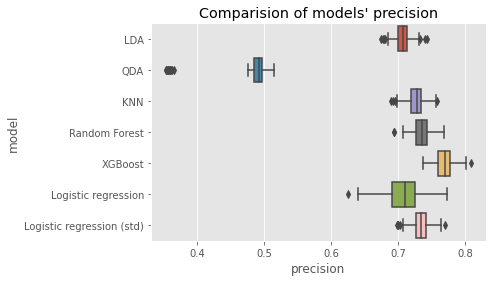

In [35]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_scores, y='model', x='precision')
plt.title("Comparision of models' precision")
plt.savefig('img/box_1_prec.pdf', bbox_inches='tight')

# KNN - optimal number of neighbours

## 1. Grid search

In [37]:
knn = KNeighborsClassifier()

In [38]:
parameters_KNN = {'n_neighbors': np.arange(1, 46, 1)}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)

In [42]:
grid_search_KNN_acc = GridSearchCV(
    estimator=knn,
    param_grid=parameters_KNN,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = cv
)

grid_search_KNN_acc.fit(X_train_e_std, y_train_e)

print(f'Best accuracy = {grid_search_KNN_acc.best_score_} for n_neighbors = {list(grid_search_KNN_acc.best_params_.values())[0]}')

Best accuracy = 0.8432020682522549 for n_neighbors = 38


In [43]:
params = np.arange(1, 46, 1)
means_acc = grid_search_KNN_acc.cv_results_['mean_test_score']

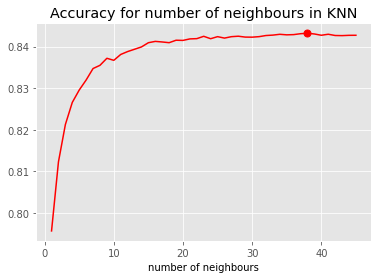

In [46]:
plt.figure(figsize=(6, 4))
plt.plot(params, means_acc, label='accuracy', color='red')
plt.plot(list(grid_search_KNN_acc.best_params_.values()), [grid_search_KNN_acc.best_score_], marker="o", markersize=7, markerfacecolor="red", markeredgecolor="red")
plt.title('Accuracy for number of neighbours in KNN')
plt.xlabel('number of neighbours')
plt.savefig('img/knn_opt_n.pdf')

# Feature selection 

## 1. Correlation based

In [21]:
fea_to_deop_corr = ['fnlwgt', 'workclass', 'from_USA']

In [22]:
df_fs = df.drop(fea_to_deop_corr, axis=1)

X_fs = df_fs.drop('income', axis=1)
y_fs = df_fs['income']
X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(X_fs, y_fs, test_size=0.25, random_state=16)

categorical_columns = df_fs.select_dtypes(include=['category']).columns.tolist()    
df_fs_enco = pd.get_dummies(df_fs, columns=categorical_columns)

X_e_fs = df_fs_enco.drop('income', axis=1)
y_e_fs = df_fs_enco['income']

X_train_e_fs, X_test_e_fs, y_train_e_fs, y_test_e_fs = train_test_split(X_e_fs, y_e_fs, test_size=0.25, random_state=16)

X_train_e_fs_std = X_train_e_fs.copy()
scaler_fs_std = preprocessing.StandardScaler().fit(X_train_e_fs[['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']])
columns_scaled = scaler_fs_std.transform(X_train_e_fs[['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']])

X_train_e_fs_std['age'] = columns_scaled[:, 0]
X_train_e_fs_std['education_num'] = columns_scaled[:, 1]
X_train_e_fs_std['capital_gain'] = columns_scaled[:, 2]
X_train_e_fs_std['capital_loss'] = columns_scaled[:, 3]
X_train_e_fs_std['hours_per_week'] = columns_scaled[:, 4]

In [23]:
lda_2 = LinearDiscriminantAnalysis()
df_scores_fs = model_scoring(lda_2, 'LDA', X_train=X_train_e_fs, y_train=y_train_e_fs)

qda_2 = QuadraticDiscriminantAnalysis()
df_scores_fs = pd.concat([df_scores_fs, model_scoring(qda_2, 'QDA', X_train=X_train_e_fs, y_train=y_train_e_fs)], ignore_index=True)

knn_2 = KNeighborsClassifier(n_neighbors=9)
df_scores_fs = pd.concat([df_scores_fs, model_scoring(knn_2, 'KNN', X_train=X_train_e_fs_std, y_train=y_train_e_fs)], ignore_index=True)

rf_2 = RandomForestClassifier()
df_scores_fs = pd.concat([df_scores_fs, model_scoring(rf_2, 'Random Forest', X_train=X_train_e_fs, y_train=y_train_e_fs)], ignore_index=True)

xg_2_cat = xgb.XGBClassifier(enable_categorical=True)
df_scores_fs = pd.concat([df_scores_fs, model_scoring(xg_2_cat, 'XGBoost', X_train=X_train_fs, y_train=y_train_fs)], ignore_index=True)

lr_2 = LogisticRegression()
df_scores_fs = pd.concat([df_scores_fs, model_scoring(lr_2, 'Logistic regression', X_train=X_train_e_fs, y_train=y_train_e_fs)], ignore_index=True)

lr_2_std = LogisticRegression()
df_scores_fs = pd.concat([df_scores_fs, model_scoring(lr_2_std, 'Logistic regression (std)', X_train=X_train_e_fs_std, y_train=y_train_e_fs)], ignore_index=True)

In [24]:
df_scores_fs.groupby('model').mean(numeric_only=True) * 100

,accuracy,roc_auc,recall,precision
model,,,,
KNN,83.547979,87.973937,60.226962,69.457557
LDA,83.550635,88.908547,58.520029,70.265168
Logistic regression,82.005581,86.253574,52.325729,67.893311
Logistic regression (std),84.581155,90.162530,60.397903,72.862674
QDA,80.440239,86.669650,35.321237,72.641111
Random Forest,83.980242,88.523700,61.913639,69.994592
XGBoost,86.650144,92.454390,65.924699,77.006327


In [40]:
df_scores.groupby('model').mean(numeric_only=True) * 100

,accuracy,roc_auc,recall,precision
model,,,,
KNN,84.313136,89.630686,59.195873,72.569098
LDA,83.702488,89.027306,58.725505,70.676662
Logistic regression,79.031406,58.317247,26.475891,70.815303
Logistic regression (std),84.745096,90.298831,60.647336,73.303195
QDA,72.573917,86.740605,87.873780,47.837720
Random Forest,85.006038,90.241734,62.079835,73.472710
XGBoost,86.649855,92.463954,66.031591,76.934490


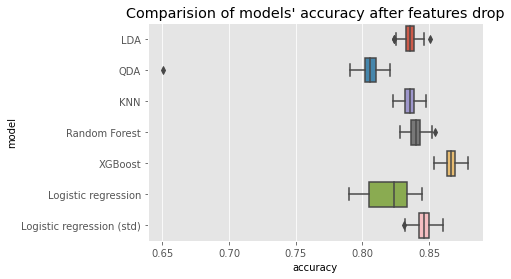

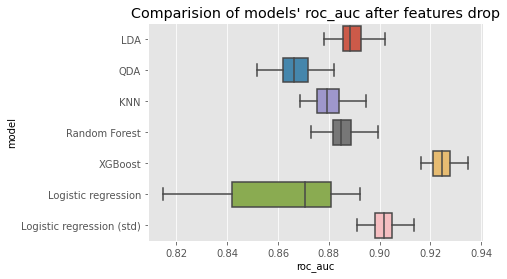

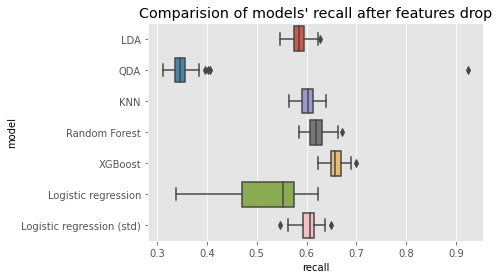

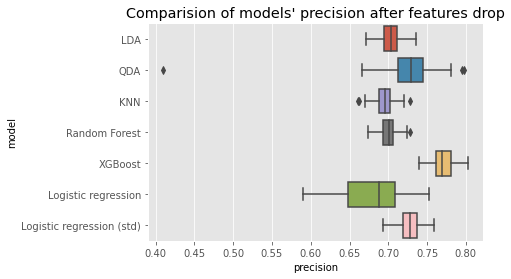

In [25]:
for scoring in ['accuracy', 'roc_auc', 'recall', 'precision']:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df_scores_fs, y='model', x=scoring)
    plt.title(f"Comparision of models' {scoring} after features drop")
    plt.savefig(f'img/box_2_{scoring}.pdf', bbox_inches='tight')
    plt.show()

## 2. Feature importance in XGBoost

In [60]:
from xgboost import plot_importance

In [43]:
xg_cat = xgb.XGBClassifier(enable_categorical=True)
xg_cat.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [44]:
xg_cat.feature_importances_

array([0.02847158, 0.01805997, 0.01247886, 0.10362081, 0.1607714 ,
       0.04400356, 0.37610447, 0.01598786, 0.0222429 , 0.12661058,
       0.05771607, 0.02440574, 0.00952621], dtype=float32)

In [45]:
xg_cat.get_booster().get_score(importance_type='gain')

{'age': 6.079583644866943,
 'workclass': 3.8563740253448486,
 'fnlwgt': 2.664630889892578,
 'education_num': 22.12632179260254,
 'marital_status': 34.32978057861328,
 'occupation': 9.396151542663574,
 'relationship': 80.3102035522461,
 'race': 3.413914203643799,
 'sex': 4.749563694000244,
 'capital_gain': 27.035362243652344,
 'capital_loss': 12.324207305908203,
 'hours_per_week': 5.211397171020508,
 'from_USA': 2.034147024154663}

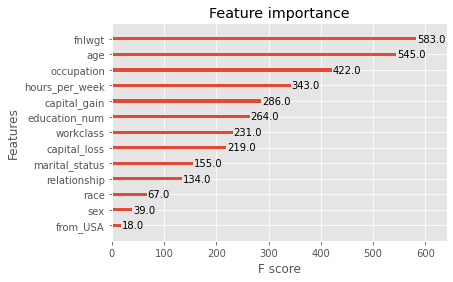

In [46]:
plot_importance(xg_cat, max_num_features=15, importance_type='weight')
# the number of times a feature is used to split the data across all trees
plt.savefig(f'img/xgboost_import_weight.pdf', bbox_inches='tight')

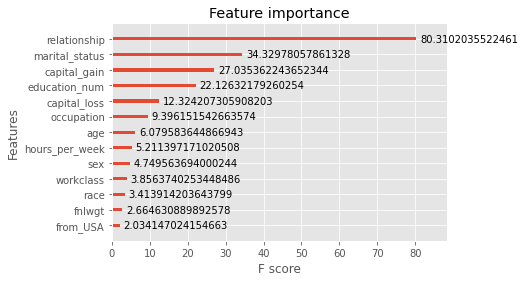

In [47]:
plot_importance(xg_cat, max_num_features=15, importance_type='gain')
# the average gain across all splits the feature is used in
plt.savefig(f'img/xgboost_import_gain.pdf', bbox_inches='tight')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

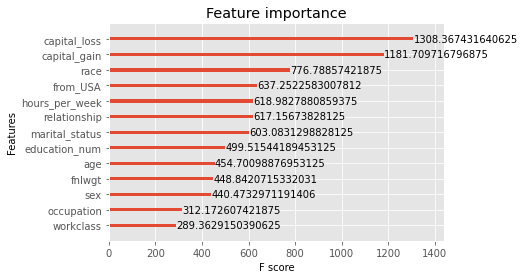

In [80]:
plot_importance(xg_cat, max_num_features=15, importance_type='cover')
# the average coverage across all splits the feature is used in

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

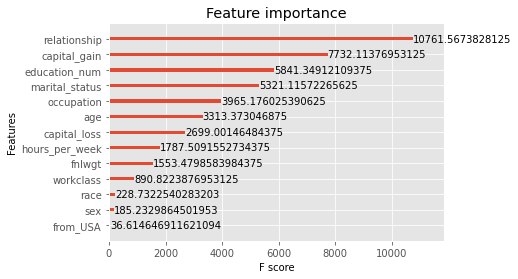

In [81]:
plot_importance(xg_cat, max_num_features=15, importance_type='total_gain')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

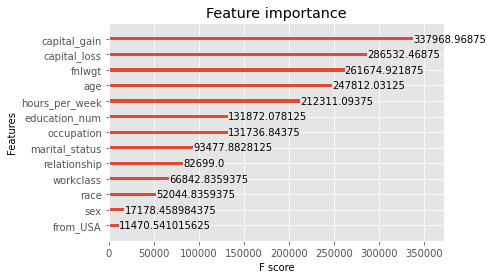

In [82]:
plot_importance(xg_cat, max_num_features=15, importance_type='total_cover')

## 2.1 Droping features based on xgboost

In [21]:
fea_to_deop_corr_gx = ['fnlwgt']

In [22]:
df_fs_gx = df.drop(fea_to_deop_corr_gx, axis=1)

X_fs_gx = df_fs_gx.drop('income', axis=1)
y_fs_gx = df_fs_gx['income']
X_train_fs_gx, X_test_fs_gx, y_train_fs_gx, y_test_fs_gx = train_test_split(X_fs_gx, y_fs_gx, test_size=0.25, random_state=16)

categorical_columns = df_fs_gx.select_dtypes(include=['category']).columns.tolist()    
df_fs_enco_gx = pd.get_dummies(df_fs_gx, columns=categorical_columns)

X_e_fs_gx = df_fs_enco_gx.drop('income', axis=1)
y_e_fs_gx = df_fs_enco_gx['income']

X_train_e_fs_gx, X_test_e_fs_gx, y_train_e_fs_gx, y_test_e_fs_gx = train_test_split(X_e_fs_gx, y_e_fs_gx, test_size=0.25, random_state=16)

X_train_e_fs_std_gx = X_train_e_fs_gx.copy()
scaler_fs_std_gx = preprocessing.StandardScaler().fit(X_train_e_fs_gx[['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']])
columns_scaled = scaler_fs_std_gx.transform(X_train_e_fs_gx[['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']])

X_train_e_fs_std_gx['age'] = columns_scaled[:, 0]
X_train_e_fs_std_gx['education_num'] = columns_scaled[:, 1]
X_train_e_fs_std_gx['capital_gain'] = columns_scaled[:, 2]
X_train_e_fs_std_gx['capital_loss'] = columns_scaled[:, 3]
X_train_e_fs_std_gx['hours_per_week'] = columns_scaled[:, 4]

In [23]:
X_test_e_fs_std_gx = X_test_e_fs_gx.copy()
columns_scaled = scaler_fs_std_gx.transform(X_test_e_fs_gx[['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']])

X_test_e_fs_std_gx['age'] = columns_scaled[:, 0]
X_test_e_fs_std_gx['education_num'] = columns_scaled[:, 1]
X_test_e_fs_std_gx['capital_gain'] = columns_scaled[:, 2]
X_test_e_fs_std_gx['capital_loss'] = columns_scaled[:, 3]
X_test_e_fs_std_gx['hours_per_week'] = columns_scaled[:, 4]

In [24]:
lda_2 = LinearDiscriminantAnalysis()
df_scores_fs_gx = model_scoring(lda_2, 'LDA', X_train=X_train_e_fs_gx, y_train=y_train_e_fs_gx)

qda_2 = QuadraticDiscriminantAnalysis()
df_scores_fs_gx = pd.concat([df_scores_fs_gx, model_scoring(qda_2, 'QDA', X_train=X_train_e_fs_gx, y_train=y_train_e_fs_gx)], ignore_index=True)

knn_2 = KNeighborsClassifier(n_neighbors=9)
df_scores_fs_gx = pd.concat([df_scores_fs_gx, model_scoring(knn_2, 'KNN', X_train=X_train_e_fs_std_gx, y_train=y_train_e_fs_gx)], ignore_index=True)

rf_2 = RandomForestClassifier()
df_scores_fs_gx = pd.concat([df_scores_fs_gx, model_scoring(rf_2, 'Random Forest', X_train=X_train_e_fs_gx, y_train=y_train_e_fs_gx)], ignore_index=True)

xg_2_cat = xgb.XGBClassifier(enable_categorical=True)
df_scores_fs_gx = pd.concat([df_scores_fs_gx, model_scoring(xg_2_cat, 'XGBoost', X_train=X_train_fs_gx, y_train=y_train_fs_gx)], ignore_index=True)

lr_2 = LogisticRegression()
df_scores_fs_gx = pd.concat([df_scores_fs_gx, model_scoring(lr_2, 'Logistic regression', X_train=X_train_e_fs_gx, y_train=y_train_e_fs_gx)], ignore_index=True)

lr_2_std = LogisticRegression()
df_scores_fs_gx = pd.concat([df_scores_fs_gx, model_scoring(lr_2_std, 'Logistic regression (std)', X_train=X_train_e_fs_std_gx, y_train=y_train_e_fs_gx)], ignore_index=True)

In [25]:
df_scores_fs_gx.groupby('model').mean(numeric_only=True) * 100

,accuracy,roc_auc,recall,precision
model,,,,
KNN,83.844300,88.179812,61.094008,70.019841
LDA,83.690106,89.014337,58.705309,70.645650
Logistic regression,82.446995,86.840332,53.430355,68.928715
Logistic regression (std),84.649266,90.284788,60.451354,73.070085
QDA,80.024273,86.763549,43.512712,72.542443
Random Forest,84.208751,88.931728,61.993161,70.737615
XGBoost,86.834145,92.573170,66.149223,77.529904


In [26]:
df_scores.groupby('model').mean(numeric_only=True) * 100

NameError: name 'df_scores' is not defined

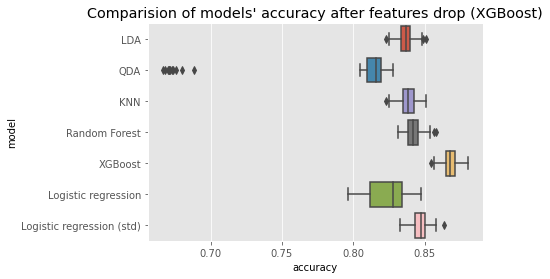

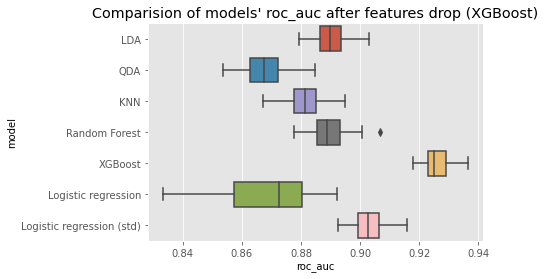

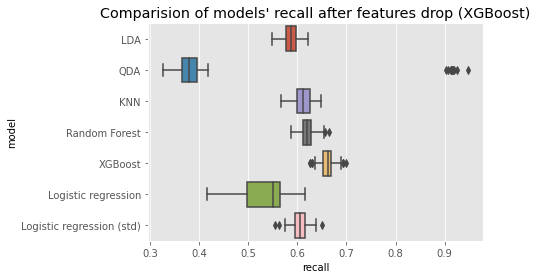

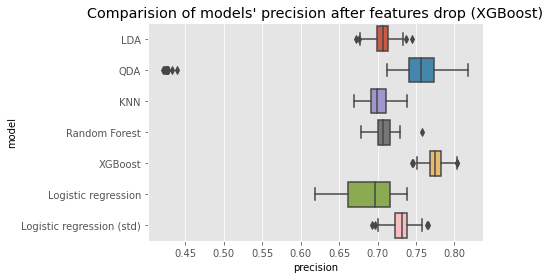

In [27]:
for scoring in ['accuracy', 'roc_auc', 'recall', 'precision']:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df_scores_fs_gx, y='model', x=scoring)
    plt.title(f"Comparision of models' {scoring} after features drop (XGBoost)")
    plt.savefig(f'img/box_3_{scoring}.pdf', bbox_inches='tight')
    plt.show()

# Hyper parameter tuning

## KNN

In [28]:
knn = KNeighborsClassifier(n_neighbors=38)

In [29]:
parameters_KNN = {'weights' : ['uniform', 'distance'], 'p' : [1,2]}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)

In [30]:
grid_search_KNN_acc = GridSearchCV(
    estimator=knn,
    param_grid=parameters_KNN,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = cv
)

grid_search_KNN_acc.fit(X_train_e_fs_std_gx, y_train_e_fs_gx)

print(f'Best accuracy = {grid_search_KNN_acc.best_score_} for n_neighbors = {list(grid_search_KNN_acc.best_params_.values())[0]}')

Best accuracy = 0.8442635228935642 for n_neighbors = 2


In [31]:
grid_search_KNN_acc.best_params_

{'p': 2, 'weights': 'uniform'}

## LDA

In [32]:
lda = LinearDiscriminantAnalysis()

In [33]:
parameters_LDA = {'solver' : ['svd', 'lsqr','eigen']}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)

In [34]:
grid_search_LDA_acc = GridSearchCV(
    estimator=lda,
    param_grid=parameters_LDA,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = cv
)

grid_search_LDA_acc.fit(X_train_e_fs_gx, y_train_e_fs_gx)

grid_search_LDA_acc.best_params_,grid_search_LDA_acc.best_score_

({'solver': 'svd'}, 0.8368804076272931)

## Random Forest

In [35]:
rf = RandomForestClassifier()

In [36]:
parameters_RF = {'n_estimators' : [80,90,100,110,120], 'criterion': ['gini', 'entropy', 'log_loss'], }
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)

In [37]:
grid_search_RF_acc = GridSearchCV(
    estimator=rf,
    param_grid=parameters_RF,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = cv
)

grid_search_RF_acc.fit(X_train_e_fs_gx, y_train_e_fs_gx)

grid_search_RF_acc.best_params_,grid_search_RF_acc.best_score_

({'criterion': 'gini', 'n_estimators': 80}, 0.8416334477223282)

## XG Boost

In [40]:
xg = xgb.XGBClassifier(tree_method='hist', enable_categorical=True)
parameters_XG = {'scale_pos_weight': [0.5, 1, 2, 3, 4], 'eta': np.arange(0.1, 0.4, 0.1), 'max_depth': [4, 5, 6]}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [41]:
grid_search_XG_acc = GridSearchCV(
    estimator=xg,
    param_grid=parameters_XG,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = cv
)

grid_search_XG_acc.fit(X_train_fs_gx, y_train_fs_gx)
grid_search_XG_acc.best_params_, grid_search_XG_acc.best_score_

({'eta': 0.30000000000000004, 'max_depth': 4, 'scale_pos_weight': 1},
 0.9276984447030503)

# Testing models on a test data

In [44]:
def prediction_assesment(model, y_true, y_pred, model_name):
    acc = metrics.accuracy_score(y_true, y_pred)
    roc = metrics.roc_auc_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    
    df_scores = pd.DataFrame({
        'model' : [model_name],
        'accuracy' : [acc],
        'ROC AUC' : [roc],
        'recall' : [recall],
        'precision' : [prec]
    })
    return df_scores

## LDA

In [45]:
lda = LinearDiscriminantAnalysis(solver='svd')
lda.fit(X_train_e_fs_gx, y_train_e_fs_gx)
y_lda_pred = lda.predict(X_test_e_fs_gx)
y_lda_prob = lda.predict_proba(X_test_e_fs_gx)

In [46]:
df_test_score = prediction_assesment(lda, y_test_e_fs_gx, y_lda_pred, 'LDA')

## QDA

In [47]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_e_fs_gx, y_train_e_fs_gx)
y_qda_pred = qda.predict(X_test_e_fs_gx)
y_qda_prob = qda.predict_proba(X_test_e_fs_gx)

In [48]:
df_test_score = pd.concat([df_test_score, prediction_assesment(qda, y_test_e_fs_gx, y_qda_pred, 'QDA')], ignore_index=True)

## KNN

In [49]:
knn = KNeighborsClassifier(n_neighbors=38, p=2, weights='uniform')
knn.fit(X_train_e_fs_std_gx, y_train_e_fs_gx)
y_knn_pred = knn.predict(X_test_e_fs_std_gx)
y_knn_prob = knn.predict_proba(X_test_e_fs_std_gx)

In [50]:
df_test_score = pd.concat([df_test_score, prediction_assesment(knn, y_test_e_fs_gx, y_knn_pred, 'KNN')], ignore_index=True)

## LR

In [51]:
lr = LogisticRegression(max_iter=300)
lr.fit(X_train_e_fs_std_gx, y_train_e_fs_gx)
y_lr_pred = lr.predict(X_test_e_fs_std_gx)
y_lr_prob = lr.predict_proba(X_test_e_fs_std_gx)

In [52]:
df_test_score = pd.concat([df_test_score, prediction_assesment(lr, y_test_e_fs_gx, y_lr_pred, 'Logistic Regression (std)')], ignore_index=True)

## RF

In [53]:
rf = RandomForestClassifier(criterion='gini', n_estimators=80)
rf.fit(X_train_e_fs_gx, y_train_e_fs_gx)
y_rf_pred = rf.predict(X_test_e_fs_gx)
y_rf_prob = rf.predict_proba(X_test_e_fs_gx)

In [54]:
df_test_score = pd.concat([df_test_score, prediction_assesment(rf, y_test_e_fs_gx, y_rf_pred, 'Random Forest')], ignore_index=True)

## XGB

In [74]:
xg = xgb.XGBClassifier(enable_categorical=True, eta=0.3, max_depth=4, n_estimators=140)
xg.fit(X_train_fs_gx, y_train_fs_gx)
y_xg_pred = xg.predict(X_test_fs_gx)
y_xg_prob = xg.predict_proba(X_test_fs_gx)

In [75]:
df_test_score = pd.concat([df_test_score, prediction_assesment(xg, y_test_fs_gx, y_xg_pred, 'XGBoost')], ignore_index=True)

In [76]:
df_test_score

,model,accuracy,ROC AUC,recall,precision
0,LDA,0.835294,0.747376,0.573888,0.703606
1,QDA,0.820522,0.675084,0.388092,0.770107
2,KNN,0.845997,0.759908,0.590029,0.733393
3,Logistic Regression (std),0.849270,0.766182,0.602224,0.738347
4,Random Forest,0.850509,0.779308,0.638809,0.722808
5,XGBoost,0.871119,0.800104,0.659971,0.783312
6,XGBoost,0.868642,0.799426,0.662841,0.772252


In [57]:
df_test_score

,model,accuracy,ROC AUC,recall,precision
0,LDA,0.835294,0.747376,0.573888,0.703606
1,QDA,0.820522,0.675084,0.388092,0.770107
2,KNN,0.845997,0.759908,0.590029,0.733393
3,Logistic Regression (std),0.849270,0.766182,0.602224,0.738347
4,Random Forest,0.850509,0.779308,0.638809,0.722808
5,XGBoost,0.871119,0.800104,0.659971,0.783312


In [58]:
df_test_score * 100

,model,accuracy,ROC AUC,recall,precision
0,LDALDALDALDALDALDALDALDALDALDALDALDALDALDALDAL...,83.529412,74.737612,57.388809,70.360598
1,QDAQDAQDAQDAQDAQDAQDAQDAQDAQDAQDAQDAQDAQDAQDAQ...,82.052189,67.508384,38.809182,77.010676
2,KNNKNNKNNKNNKNNKNNKNNKNNKNNKNNKNNKNNKNNKNNKNNK...,84.599735,75.990809,59.002869,73.339278
3,Logistic Regression (std)Logistic Regression (...,84.927023,76.618177,60.222382,73.834653
4,Random ForestRandom ForestRandom ForestRandom ...,85.050862,77.930831,63.880918,72.280844
5,XGBoostXGBoostXGBoostXGBoostXGBoostXGBoostXGBo...,87.111897,80.010424,65.997131,78.331205


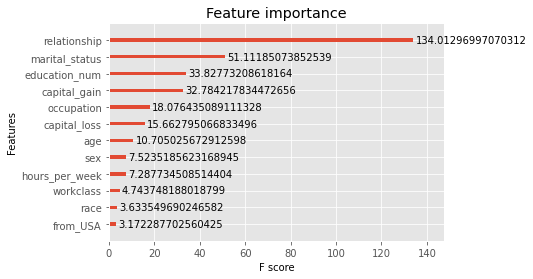

In [61]:
plot_importance(xg, max_num_features=15, importance_type='gain')
plt.savefig(f'img/xgboost_import_gain_2.pdf', bbox_inches='tight')

# ROC Curve

In [62]:
fpr_qda, tpr_qda, thresholds_qda = metrics.roc_curve(y_test_e_fs_gx, y_qda_prob[:, 1])
precision_qda, recall_qda, thresholds_qda_2 = metrics.precision_recall_curve(y_test_e_fs_gx, y_qda_prob[:, 1])

In [63]:
fpr_lda, tpr_lda, thresholds_lda = metrics.roc_curve(y_test_e_fs_gx, y_lda_prob[:, 1])
precision_lda, recall_lda, thresholds_lda_2 = metrics.precision_recall_curve(y_test_e_fs_gx, y_lda_prob[:, 1])

In [64]:
fpr_knn, tpr_knn, thresholds_knn = metrics.roc_curve(y_test_e_fs_gx, y_knn_prob[:, 1])
precision_knn, recall_knn, thresholds_knn_2  = metrics.precision_recall_curve(y_test_e_fs_gx, y_knn_prob[:, 1])

In [65]:
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y_test_e_fs_gx, y_lr_prob[:, 1])
precision_lr, recall_lr, thresholds_lr_2 = metrics.precision_recall_curve(y_test_e_fs_gx, y_lr_prob[:, 1])

In [66]:
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test_e_fs_gx, y_rf_prob[:, 1])
precision_rf, recall_rf, thresholds_rf_2 = metrics.precision_recall_curve(y_test_e_fs_gx, y_rf_prob[:, 1])

In [67]:
fpr_xg, tpr_xg, thresholds_xg = metrics.roc_curve(y_test_fs_gx, y_xg_prob[:, 1])
precision_xg, recall_xg, thresholds_xg_2 = metrics.precision_recall_curve(y_test_fs_gx, y_xg_prob[:, 1])

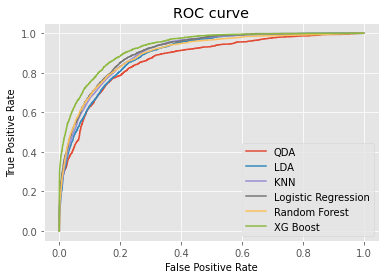

In [68]:
plt.figure(figsize=(6, 4))
plt.plot(fpr_qda, tpr_qda, label='QDA')
plt.plot(fpr_lda, tpr_lda, label='LDA') 
plt.plot(fpr_knn, tpr_knn, label='KNN') 
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression') 
plt.plot(fpr_rf, tpr_rf, label='Random Forest') 
plt.plot(fpr_xg, tpr_xg, label='XG Boost') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.savefig(f'img/roc_curve.pdf')

In [69]:
y_qda_pred

array([0, 0, 0, ..., 0, 0, 0])

In [70]:
np.argmin((fpr_xg[1:])**2 + (1-tpr_xg[1:])**2)

1420

In [71]:
np.round(thresholds_xg[1420], 4)

0.267

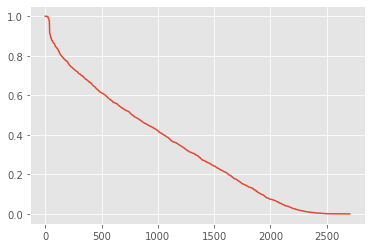

In [72]:
plt.plot(thresholds_xg[1:])

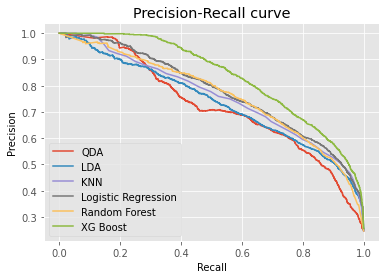

In [73]:
plt.figure(figsize=(6, 4))
plt.plot(recall_qda, precision_qda, label='QDA')
plt.plot(recall_lda, precision_lda, label='LDA') 
plt.plot(recall_knn, precision_knn, label='KNN') 
plt.plot(recall_lr, precision_lr, label='Logistic Regression') 
plt.plot(recall_rf, precision_rf, label='Random Forest') 
plt.plot(recall_xg, precision_xg, label='XG Boost') 
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()
plt.savefig(f'img/prec_recall_curve.pdf')